In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
patients = pd.read_csv(r"C:\Users\sonal\OneDrive\Documents\Healthcare Risk Stratification Model\patients.csv")
diagnoses = pd.read_csv(r"C:\Users\sonal\OneDrive\Documents\Healthcare Risk Stratification Model\diagnoses.csv")
outcomes = pd.read_csv(r"C:\Users\sonal\OneDrive\Documents\Healthcare Risk Stratification Model\outcomes.csv")
labs = pd.read_csv(r"C:\Users\sonal\OneDrive\Documents\Healthcare Risk Stratification Model\labs.csv")

In [ ]:
# Merge datasets
patients = patients.merge(diagnoses, on='DiagnosisID')
patients = patients.merge(outcomes, on='OutcomeID')

# Fix date processing 
patients['AdmissionDate'] = pd.to_datetime(patients['AdmissionDate'], format='%d-%m-%Y', errors='coerce')
patients['DischargeDate'] = pd.to_datetime(patients['DischargeDate'], format='%d-%m-%Y', errors='coerce')
patients['LengthOfStay'] = (patients['DischargeDate'] - patients['AdmissionDate']).dt.days

patients['LengthOfStay'] = patients['LengthOfStay'].clip(lower=0)

In [46]:
patients['OutcomeEncoded'] = patients['OutcomeName'].map({'Recovered': 0, 'Complicated': 1, 'Deceased': 1})

patients['HighRisk'] = np.where(
    (patients['Age'] > 65) & (patients['OutcomeName'].isin(['Complicated', 'Deceased'])), 1, 0
)

In [47]:
abnormal_conditions = {
    'Blood Pressure': lambda x: (x > 140) if 'Blood Pressure' in str(x) else False,  # Systolic > 140
    'Blood Sugar': lambda x: x > 126,  # Fasting blood sugar > 126 mg/dL
    'Cholesterol': lambda x: x > 200,  # Total cholesterol > 200 mg/dL
    'Hemoglobin': lambda x: (x < 13) if pd.notna(x) else False,  # Low hemoglobin
    'Creatinine': lambda x: x > 1.2,  # High creatinine
    'Vitamin D': lambda x: x < 20     # Low vitamin D
}

def count_abnormal_labs(patient_id):
    patient_labs = labs[labs['PatientID'] == patient_id] 
    count = 0
    for test_name, condition in abnormal_conditions.items():
        test_results = patient_labs[patient_labs['TestName'] == test_name]
        if not test_results.empty:
            count += test_results['Result'].apply(condition).sum()
    return count


patients['AbnormalLabCount'] = patients['PatientID'].apply(count_abnormal_labs)

Model Training

In [49]:
features = patients[['Age', 'LengthOfStay', 'TreatmentCost', 'AbnormalLabCount']]
target = patients['OutcomeEncoded']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


features = features.fillna(features.mean())


X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42, stratify=target
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.68      1.00      0.81        41

    accuracy                           0.68        60
   macro avg       0.34      0.50      0.41        60
weighted avg       0.47      0.68      0.55        60



D:\Anaconda_python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda_python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda_python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC CURVE

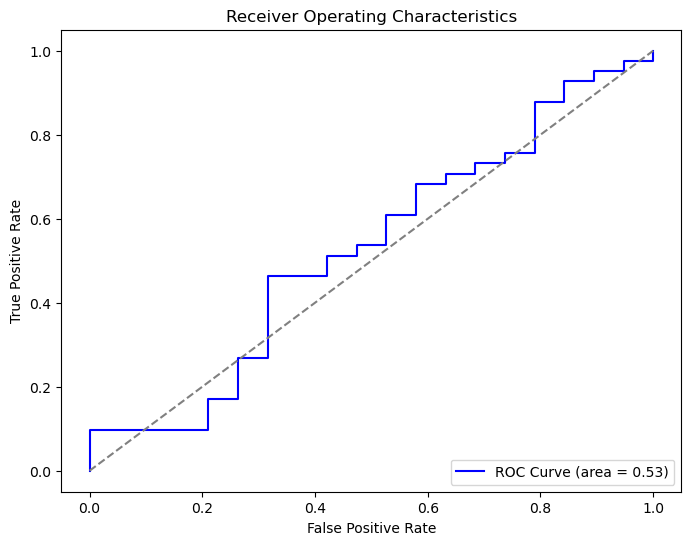

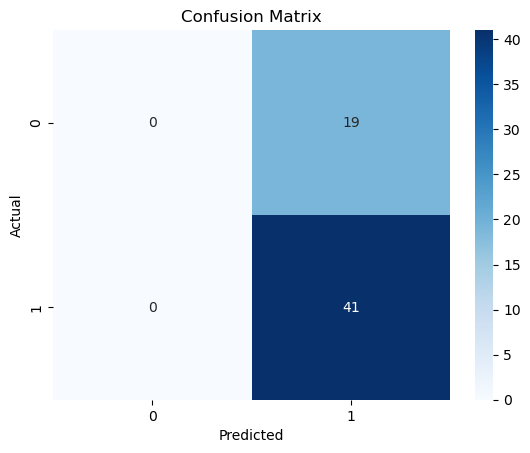

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [54]:
import joblib

joblib.dump({'model': model, 'scaler': scaler}, 'healthcare_risk_model.pkl')
print("Model saved successfully!")

Model saved successfully!
